In [ ]:
import datetime

current_datetime=datetime.datetime.now()
print(f"Calf was last happy on: {current_datetime.strftime('%Y-%m-%d %H:%M:%S')}")

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import os
import random
import io
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage
import tensorflow as tf
import pathlib
import itertools
import random

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

from object_detection.utils import config_util
from object_detection.builders import model_builder
%matplotlib inline

In [ ]:
print(tf.config.list_physical_devices('GPU'))
!nvidia-smi
# !kill -9 1618764
gpu_memory_fraction = 0.8
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth for each GPU
        for gpu in gpus:
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=int(gpu_memory_fraction * 1024))]
            )
    except RuntimeError as e:
        print(e)
# tf.keras.mixed_precision.set_global_policy('mixed_float16')


In [ ]:
# Download EfficientDet model 
# TODO: 
# 1. Configure the directory path for the model download.


# import wget
# model_link = "http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz"
# model_tar_name="efficientdet_d0_coco17_tpu-32.tar.gz"

# # Check if model is already downloadeds
# if not os.path.exists(model_tar_name):
#     wget.download(model_link)
#     # Unzip
#     !tar -zxvf {model_tar_name} 
# else:
#     print(f"Model {model_tar_name} already downloaded")

In [ ]:
# Training the model
# !python3 Calf_Detection//models/research/object_detection/model_main_tf2.py \
#     --pipeline_config_path=Calf_Detection/new_app/config/efficientdet_d0_coco17_tpu-32.config \
#     --model_dir=Calf_Detection/new_app/training_ed0_epochs_100 \
#     --alsologtostderr

# # Training the model d1
# !python3 ./models/research/object_detection/model_main_tf2.py \
#     --pipeline_config_path=new_app/New_Models/config/efficientdet_d1_coco17_tpu-32.config \
#     --model_dir=new_app/New_Models/training/efficientdet_d1_coco17_tpu-32 \
#     --alsologtostderr


In [ ]:
# Visualization in tensorboard 
# Todo:
# 1. Check Tensorboard visualization
# !cd Calf_Detection/new_app/training_ed0_epochs_100 && tensorboard --logdir=.



In [ ]:
# Export the model d0
# pipeline_file = 'Calf_Detection/new_app/config/efficientdet_d0_coco17_tpu-32.config'
# last_model_path = 'Calf_Detection/new_app/training_ed0_epochs_100'
# output_directory = "Calf_Detection/new_app/finetuned_ed0_epochs_100"
# !python3 Calf_Detection/models/research/object_detection/exporter_main_v2.py \
#     --trained_checkpoint_dir {last_model_path} \
#     --output_directory {output_directory} \
#     --pipeline_config_path {pipeline_file}

# # Export the model d1
# pipeline_file = 'new_app/New_Models/config/efficientdet_d1_coco17_tpu-32.config'
# last_model_path = 'new_app/New_Models/training/efficientdet_d1_coco17_tpu-32'
# output_directory = "new_app/New_Models/finetuned/efficientdet_d1_coco17_tpu-32"
# !python3 models/research/object_detection/exporter_main_v2.py \
#     --trained_checkpoint_dir {last_model_path} \
#     --output_directory {output_directory} \
#     --pipeline_config_path {pipeline_file}

In [ ]:
pipeline_file = 'Calf_Detection/new_app/New_Models/config/efficientdet_d0_coco17_tpu-32.config'
last_model_path = 'Calf_Detection/new_app/New_Models/training/epochs_10/efficientdet_d0_coco17_tpu-32'
output_directory = "Calf_Detection/new_app/New_Models/finetuned/efficientdet_d0_coco17_tpu-32"

import pathlib

def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.
  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.
  Args:
    path: a file path.
  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

filenames = list(pathlib.Path('Calf_Detection/new_app/New_Models/training/epochs_10/efficientdet_d0_coco17_tpu-32').glob('*.index'))
filenames.sort()

# recover our saved model
model_dir = 'Calf_Detection/new_app/New_Models/training/epochs_10/efficientdet_d0_coco17_tpu-32'
# Adding the last checkpoint
configs = config_util.get_configs_from_pipeline_file(pipeline_file)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

print(detection_model)
# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join(str(filenames[-1]).replace('.index',''))).expect_partial()
print(os.path.join(str(filenames[-1]).replace('.index','')))

def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)
# map labels for inference decoding
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)
#run detector on test image
#it takes a little longer on the first run and then runs at normal speed. 

TEST_IMAGE_PATHS = glob.glob('Calf_Detection/new_app/test/2018-11-20_000001.jpg')

image_path = random.choice(TEST_IMAGE_PATHS)
image_np = load_image_into_numpy_array(image_path)

input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=1,
      min_score_thresh=.1,
      agnostic_mode=False,
)

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.axis("off")
plt.show()

In [ ]:
# import time

# sample_image_path = 'Calf_Detection/new_app/test/2019-06-29_090001.jpg'
# sample_image_np = load_image_into_numpy_array(sample_image_path)

# # Define the number of inference iterations

# # Assuming 24 fps x 60 seconds = 1440 frames per minute
# num_iterations = 1440

# total_inference_time = 0

# for _ in range(num_iterations):
#     input_tensor = tf.convert_to_tensor(
#         np.expand_dims(sample_image_np, 0), dtype=tf.float32)

#     start_time = time.time()
#     detections, predictions_dict, shapes = detect_fn(input_tensor)
#     end_time = time.time()
    
#     inference_time = end_time - start_time
#     total_inference_time += inference_time

# average_inference_time = total_inference_time 
# print(f"Total Inference Time for 1 Minute: {average_inference_time:.5f} seconds")


In [ ]:
#Evaluate the model
# !python3 Calf_Detection/models/research/object_detection/model_main_tf2.py \
#     --pipeline_config_path=Calf_Detection/new_app/config/efficientdet_d0_coco17_tpu-32.config \
#     --model_dir=Calf_Detection/new_app/training_ed0 \
#     --checkpoint_dir=Calf_Detection/new_app/training_ed0 \
#     --alsologtostderr


In [8]:
# Metric Evaluation

import tensorflow as tf
import numpy as np
from object_detection.utils import config_util
from object_detection.builders import model_builder
import xml.etree.ElementTree as ET
import glob

# Paths setup
TEST_IMAGE_PATHS = glob.glob('Calf_Detection/new_app/test/*.jpg')

# Metrics Initialization
false_negative = 0
true_negative = 0
true_positive = 0
false_positive = 0
total_ground_truth = len(TEST_IMAGE_PATHS)
low_iou_images = []
pipeline_file = 'Calf_Detection/new_app/New_Models/config/efficientdet_d0_coco17_tpu-32.config'
last_model_path = 'Calf_Detection/new_app/New_Models/training/epochs_10/efficientdet_d0_coco17_tpu-32'
output_directory = "Calf_Detection/new_app/New_Models/finetuned/epochs_10/efficientdet_d0_coco17_tpu-32"
filenames = list(pathlib.Path('Calf_Detection/new_app/New_Models/training/epochs_10/efficientdet_d0_coco17_tpu-32').glob('*.index'))
filenames.sort()
model_dir = 'Calf_Detection/new_app/training_ed0_epochs_100'

def load_image_into_numpy_array(path):
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def compute_iou(boxA, boxB):
    """Computes Intersection over Union (IoU) between two bounding boxes."""
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

def extract_bbox_from_xml(xml_path):
    """Extracts bounding box information from an XML annotation file."""
    tree = ET.parse(xml_path)
    root = tree.getroot()
    for member in root.findall('object'):
        bbox = member.find('bndbox')
        return [int(bbox.find(pos).text) for pos in ['xmin', 'ymin', 'xmax', 'ymax']]

def get_ground_truth_for_image(image_path):
    """Gets ground truth bounding box for a given image."""
    xml_path = image_path.replace('.jpg', '.xml')  
    return extract_bbox_from_xml(xml_path)

def load_model(pipeline_file, model_dir):
    """Loads the saved model from checkpoint."""
    configs = config_util.get_configs_from_pipeline_file(pipeline_file)
    model_config = configs['model']
    detection_model = model_builder.build(model_config=model_config, is_training=False)
    
    # Restore checkpoint
    filenames = list(pathlib.Path(model_dir).glob('*.index'))
    filenames.sort()
    checkpoint_path = str(filenames[-1]).replace('.index','')
    ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
    ckpt.restore(checkpoint_path).expect_partial()
    
    return detection_model

def detect_objects(detection_model, image_np):
    """Detects objects in an image using the trained model."""
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor, detection_model)
    return detections

@tf.function
def detect_fn(image, model):
    """TF function for object detection."""
    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)
    return detections

# Loading model
detection_model = load_model(pipeline_file, model_dir)
thresholds = np.linspace(0, 1, 50)  # For example, 50 thresholds from 0 to 1
tpr_list = []  # Store true positive rates for each threshold
fpr_list = []  # Store false positive rates for each threshold


for image_path in TEST_IMAGE_PATHS:
    image_np = load_image_into_numpy_array(image_path)
    detections = detect_objects(detection_model, image_np)
    
    detection_boxes = detections['detection_boxes'][0].numpy()
    detection_scores = detections['detection_scores'][0].numpy()
    valid_indices = np.where(detection_scores >= 0.5)[0]
    valid_boxes = detection_boxes[valid_indices]

    ground_truth_box = get_ground_truth_for_image(image_path)

    # If no ground truth for this image, assume it means no calf present
    if not ground_truth_box:
        if len(valid_boxes) == 0:  # No detections
            true_negative += 1
        else:
            false_positive += 1  # Model detected something when it shouldn't have
        continue  # Move to the next image

    # Normalize the ground truth bounding box
    img_height, img_width, _ = image_np.shape
    normalized_gt_box = [
        ground_truth_box[1] / img_width,   # xmin
        ground_truth_box[0] / img_height,  # ymin
        ground_truth_box[3] / img_width,   # xmax
        ground_truth_box[2] / img_height   # ymax
    ]

    detected = any(compute_iou(box, normalized_gt_box) >= 0.50 for box in valid_boxes)

    if detected:
        true_positive += 1
    else:
        false_negative += 1  # Model didn't detect when it should have
        low_iou_images.append(image_path)

precision = true_positive / (true_positive + false_positive)
recall = true_positive / total_ground_truth
accuracy = (true_positive + true_negative) / total_ground_truth

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
print(f"TP: {true_positive}")
print(f"FP: {false_positive}")
print(f"TN: {true_negative}")
print(f"FN: {false_negative}")

print("\nImages that didn't meet the threshold:")
for img in low_iou_images:
    print(img)

print(len(low_iou_images))

IndexError: list index out of range

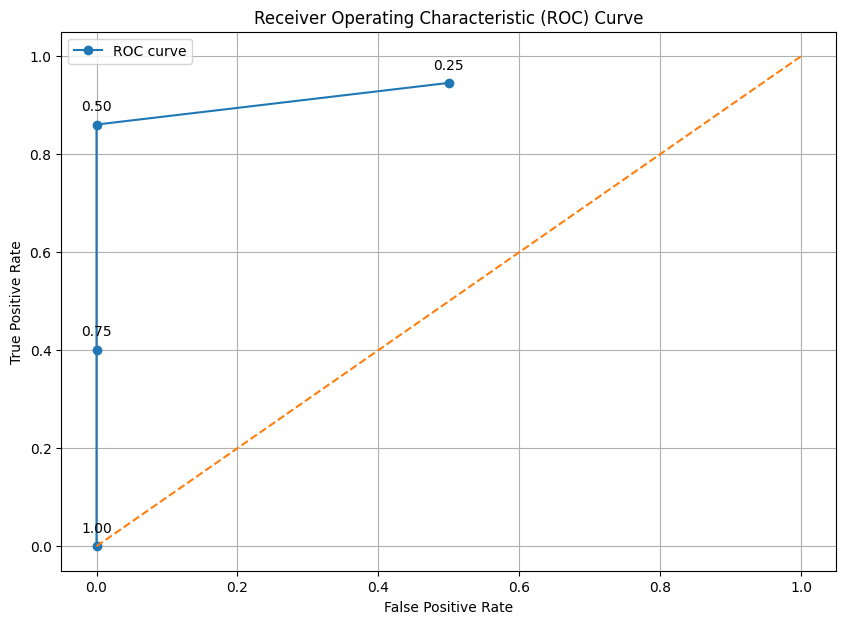

In [7]:
# Metric Evaluation

import tensorflow as tf
import numpy as np
from object_detection.utils import config_util
from object_detection.builders import model_builder
import xml.etree.ElementTree as ET
import glob

# Paths setup
TEST_IMAGE_PATHS = glob.glob('Calf_Detection/new_app/test/*.jpg')

# Metrics Initialization
false_negative = 0
true_negative = 0
true_positive = 0
false_positive = 0
total_ground_truth = len(TEST_IMAGE_PATHS)
low_iou_images = []

def compute_iou(boxA, boxB):
    """Computes Intersection over Union (IoU) between two bounding boxes."""
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

def extract_bbox_from_xml(xml_path):
    """Extracts bounding box information from an XML annotation file."""
    tree = ET.parse(xml_path)
    root = tree.getroot()
    for member in root.findall('object'):
        bbox = member.find('bndbox')
        return [int(bbox.find(pos).text) for pos in ['xmin', 'ymin', 'xmax', 'ymax']]

def get_ground_truth_for_image(image_path):
    """Gets ground truth bounding box for a given image."""
    xml_path = image_path.replace('.jpg', '.xml')  
    return extract_bbox_from_xml(xml_path)

def load_model(pipeline_file, model_dir):
    """Loads the saved model from checkpoint."""
    configs = config_util.get_configs_from_pipeline_file(pipeline_file)
    model_config = configs['model']
    detection_model = model_builder.build(model_config=model_config, is_training=False)
    
    # Restore checkpoint
    filenames = list(pathlib.Path(model_dir).glob('*.index'))
    filenames.sort()
    checkpoint_path = str(filenames[-1]).replace('.index','')
    ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
    ckpt.restore(checkpoint_path).expect_partial()
    
    return detection_model

def detect_objects(detection_model, image_np):
    """Detects objects in an image using the trained model."""
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor, detection_model)
    return detections

@tf.function
def detect_fn(image, model):
    """TF function for object detection."""
    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)
    return detections

thresholds = [0.25, 0.50, 0.75, 1.00]
tpr_list = []
fpr_list = []

for threshold in thresholds:
    # Reset the metrics for each threshold
    false_negative = 0
    true_negative = 0
    true_positive = 0
    false_positive = 0
    
    for image_path in TEST_IMAGE_PATHS:
        image_np = load_image_into_numpy_array(image_path)
        detections = detect_objects(detection_model, image_np)
        
        detection_boxes = detections['detection_boxes'][0].numpy()
        detection_scores = detections['detection_scores'][0].numpy()
        valid_indices = np.where(detection_scores >= threshold)[0]
        valid_boxes = detection_boxes[valid_indices]

        ground_truth_box = get_ground_truth_for_image(image_path)

        if not ground_truth_box:
            if len(valid_boxes) == 0:
                true_negative += 1
            else:
                false_positive += 1
            continue

        img_height, img_width, _ = image_np.shape
        normalized_gt_box = [
            ground_truth_box[1] / img_width,
            ground_truth_box[0] / img_height,
            ground_truth_box[3] / img_width,
            ground_truth_box[2] / img_height
        ]
        detected = any(compute_iou(box, normalized_gt_box) >= 0.50 for box in valid_boxes)

        if detected:
            true_positive += 1
        else:
            false_negative += 1
    
    tpr = true_positive / (true_positive + false_negative) if (true_positive + false_negative) != 0 else 0.0
    if (false_positive + true_negative) == 0:
        fpr = 0.0
    else:
        fpr = false_positive / (false_positive + true_negative)
    
    tpr_list.append(tpr)
    fpr_list.append(fpr)

# Plot the ROC curve
plt.figure(figsize=(10, 7))
plt.plot(fpr_list, tpr_list, '-o', label='ROC curve')
plt.plot([0, 1], [0, 1], linestyle='--')

# Annotate each point with its threshold value
for i, threshold in enumerate(thresholds):
    plt.annotate(f"{threshold:.2f}", (fpr_list[i], tpr_list[i]), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
save_path = 'Calf_Detection/new_app/New_Models/graphs/roc_curve_d0.png'

# Save the plot to the specified path
plt.savefig(save_path, bbox_inches='tight')
plt.show()

In [ ]:
# 1. Copy the images from low_iou_images to a new directory
import shutil
NEW_DIR = "Calf_Detection/new_app/low_iou_images_dir"
if not os.path.exists(NEW_DIR):
    os.makedirs(NEW_DIR)

for image_path in low_iou_images:
    shutil.copy(image_path, NEW_DIR)

# 2. Draw bounding boxes and detection scores on those images
def draw_boxes_on_image(image, detection_boxes, detection_scores, threshold=0.5):
    draw = ImageDraw.Draw(image)
    img_width, img_height = image.size
    for box, score in zip(detection_boxes, detection_scores):
        if score >= threshold:
            y_min, x_min, y_max, x_max = box
            # Convert normalized coordinates to pixel values
            left, right, top, bottom = x_min * img_width, x_max * img_width, y_min * img_height, y_max * img_height
            draw.rectangle([(left, top), (right, bottom)], outline="green", width=2)
            label = f"Score: {score:.2f}"
            # Using PIL might not have fonts by default, so adjusting the text size instead
            draw.text((left, top - 12), label, fill="green")
    return image

for image_path in low_iou_images:
    image = Image.open(image_path)
    detections = detect_objects(detection_model, image)
    detection_boxes = detections['detection_boxes'][0].numpy()
    detection_scores = detections['detection_scores'][0].numpy()
    image = draw_boxes_on_image(image, detection_boxes, detection_scores)
    image.save(os.path.join(NEW_DIR, os.path.basename(image_path)))

# 3. Visualize all these images in a single matplotlib frame using subplots
num_images = len(low_iou_images)
cols = 5  # Number of columns in the subplot grid (you can adjust this)
rows = int(num_images / cols) + 1  # Calculate the number of rows required

fig, axs = plt.subplots(rows, cols, figsize=(20, 20))
fig.tight_layout()

for idx, ax in enumerate(axs.ravel()):
    if idx < num_images:
        image_path = os.path.join(NEW_DIR, os.path.basename(low_iou_images[idx]))
        image = Image.open(image_path)
        ax.imshow(image)
        ax.axis("off")
    else:
        ax.axis("off")  # Turn off any unused subplots

plt.show()
